# Audio vs Sensores: ¿Qué reflejan los ultrasonidos?

Objetivo: extraer características de audio de los WAV etiquetados como ultrasonidos y comparar su relación con `hours_since_watering` y con variables de sensores. Buscamos detectar si el audio se alinea más con el objetivo de horas sin riego o con otros sensores.

Pasos:
- Cargar dataset enriquecido con sensores.
- Filtrar WAVs etiquetados como ultrasonidos.
- Extraer características de audio (energía, espectro, MFCC, ratios alta frecuencia).
- Analizar correlaciones audio ↔ objetivo/sensores.
- Probar modelos simples (Ridge) para predecir cada variable desde audio y comparar R².

In [1]:
# Imports y configuración
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

import librosa
import librosa.feature as lf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

sns.set(style='whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

REPO_ROOT = Path('/home/gti/ibmcp').resolve()
CSV_PATH = REPO_ROOT / 'results_task3' / 'plant_ultrasound_dataset_with_sensors.csv'
CACHE_DIR = REPO_ROOT / 'results_task3'
FEATURES_CSV = CACHE_DIR / 'audio_features_ultra.csv'
TARGET = 'hours_since_watering'
RANDOM_STATE = 42
SR = None  # Mantener SR nativo (evita perder ultrasonidos)
HF_CUTOFFS = [10000, 20000, 30000, 40000]  # ratios de energía por encima de 10k/20k/30k/40k, si lo permite Nyquist

CSV_PATH.exists(), CSV_PATH

(True,
 PosixPath('/home/gti/ibmcp/results_task3/plant_ultrasound_dataset_with_sensors.csv'))

In [5]:
# Carga del dataset y detección de WAVs de ultrasonido
if not CSV_PATH.exists():
    raise FileNotFoundError(f'No se encontró el CSV en {CSV_PATH}')
df = pd.read_csv(CSV_PATH)
print('Dimensiones:', df.shape)

# Resolver columna de ruta de audio
AUDIO_COL = 'full_path' if 'full_path' in df.columns else ('audio_path' if 'audio_path' in df.columns else None)
if AUDIO_COL is None:
    raise KeyError('No se encontró columna de ruta de audio (full_path/audio_path) en el dataset')
df[AUDIO_COL] = df[AUDIO_COL].astype(str)

# En este dataset: todos los archivos son ultrasonidos (no filtramos)
ultra_mask = pd.Series(True, index=df.index)
used_flag = 'asumido: todos ultrasonidos (dataset)'

df_ultra = df[ultra_mask].copy()
print(f'Filtro ultrasonidos por: {used_flag} | filas: {len(df_ultra)}')

# Filtrar a archivos existentes
df_ultra['_path'] = df_ultra[AUDIO_COL].apply(lambda p: str(Path("../" + p)))
exists_mask = df_ultra['_path'].apply(lambda p: Path(p).exists())
missing_n = (~exists_mask).sum()
if missing_n:
    print(f'Aviso: {missing_n} archivos no existen y se omitirán')
df_ultra = df_ultra[exists_mask].copy()
len(df_ultra), df_ultra.head(2)[[AUDIO_COL, TARGET]].head()

Dimensiones: (5813, 32)
Filtro ultrasonidos por: asumido: todos ultrasonidos (dataset) | filas: 5813


(5813,
                                           audio_path  hours_since_watering
 0  data/PUA.02/audiofiles/PUA076/ch2PUA_2025-02-0...            133.931111
 1  data/PUA.02/audiofiles/PUA076/ch2PUA_2025-02-0...            137.099444)

### Nota sobre el filtrado de ultrasonidos
En este dataset todos los registros son ya de ultrasonidos, así que no aplicamos filtro adicional. Si en el futuro hubiera mezcla, añade una columna booleana (p.ej. `is_ultrasound`) o utiliza `label` para separar.

In [6]:
# Extracción de características de audio
def extract_audio_features(path: str, sr: int | None = SR) -> Dict[str, Any]:
    try:
        y, sr_ = librosa.load(path, sr=sr, mono=True)
        if y is None or len(y) == 0:
            return None
        duration = len(y) / sr_
        # STFT para espectro (ajuste n_fft según SR)
        n_fft = 8192 if sr_ >= 96000 else 2048
        hop_length = n_fft // 4
        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
        pwr = (S ** 2).mean(axis=1)
        freqs = librosa.fft_frequencies(sr=sr_, n_fft=n_fft)
        total_energy = pwr.sum() + 1e-12

        # Features básicos
        rms = librosa.feature.rms(y=y)[0]
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        centroid = librosa.feature.spectral_centroid(S=S, sr=sr_)[0]
        bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr_)[0]
        rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr_, roll_percent=0.85)[0]
        flatness = librosa.feature.spectral_flatness(S=S)[0]
        mfcc = librosa.feature.mfcc(y=y, sr=sr_, n_mfcc=13)

        # Ratios de energía en altas frecuencias
        ratios = {}
        for c in HF_CUTOFFS:
            if c < freqs.max():
                mask = freqs >= c
                ratios[f'hf_ratio_{int(c//1000)}k'] = float(pwr[mask].sum() / total_energy)

        feats = {
            'sr_hz': int(sr_),
            'duration_s': duration,
            'rms_mean': float(rms.mean()), 'rms_std': float(rms.std()),
            'zcr_mean': float(zcr.mean()),
            'centroid_mean': float(centroid.mean()),
            'bandwidth_mean': float(bandwidth.mean()),
            'rolloff85_mean': float(rolloff.mean()),
            'flatness_mean': float(flatness.mean()),
        }
        # MFCC medias
        for i in range(mfcc.shape[0]):
            feats[f'mfcc{i+1}_mean'] = float(mfcc[i].mean())
        feats.update(ratios)
        return feats
    except Exception as e:
        return None  # manejamos errores fuera

# Probar en 1 muestra
sample_path = df_ultra['_path'].iloc[0] if len(df_ultra) else None
if sample_path:
    print('Ejemplo extracción en:', sample_path)
    _ = extract_audio_features(sample_path)
    print('n_feats =', len(_) if _ else None)

Ejemplo extracción en: ../data/PUA.02/audiofiles/PUA076/ch2PUA_2025-02-05_05-44-50.wav
n_feats = 26
n_feats = 26


/home/gti/.conda/envs/ibmcp/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [7]:
# Ejecutar extracción (con caché en CSV)
if FEATURES_CSV.exists():
    print('Cargando características cacheadas de', FEATURES_CSV)
    feats_df = pd.read_csv(FEATURES_CSV)
else:
    rows = []
    for i, row in df_ultra.iterrows():
        p = row['_path']
        f = extract_audio_features(p)
        if f is None:
            continue
        f['path'] = p
        rows.append(f)
        if len(rows) % 200 == 0:
            print(f'Procesados {len(rows)} archivos...')
    feats_df = pd.DataFrame(rows)
    if len(feats_df):
        CACHE_DIR.mkdir(parents=True, exist_ok=True)
        feats_df.to_csv(FEATURES_CSV, index=False)
        print('Guardado cache en', FEATURES_CSV)

len(feats_df), feats_df.head(3)

Procesados 200 archivos...
Procesados 400 archivos...
Procesados 400 archivos...
Procesados 600 archivos...
Procesados 600 archivos...
Procesados 800 archivos...
Procesados 800 archivos...
Procesados 1000 archivos...
Procesados 1000 archivos...
Procesados 1200 archivos...
Procesados 1200 archivos...
Procesados 1400 archivos...
Procesados 1400 archivos...
Procesados 1600 archivos...
Procesados 1600 archivos...
Procesados 1800 archivos...
Procesados 1800 archivos...
Procesados 2000 archivos...
Procesados 2000 archivos...
Procesados 2200 archivos...
Procesados 2200 archivos...
Procesados 2400 archivos...
Procesados 2400 archivos...
Procesados 2600 archivos...
Procesados 2600 archivos...
Procesados 2800 archivos...
Procesados 2800 archivos...
Procesados 3000 archivos...
Procesados 3000 archivos...
Procesados 3200 archivos...
Procesados 3200 archivos...
Procesados 3400 archivos...
Procesados 3400 archivos...
Procesados 3600 archivos...
Procesados 3600 archivos...
Procesados 3800 archivos...

(5813,
     sr_hz  duration_s  rms_mean   rms_std  zcr_mean  centroid_mean  bandwidth_mean  rolloff85_mean  flatness_mean  mfcc1_mean  mfcc2_mean  mfcc3_mean  mfcc4_mean  mfcc5_mean  mfcc6_mean  mfcc7_mean  \
 0  300000     0.26384  0.027246  0.007157  0.209114   66460.168166    46384.180036   122524.789663       0.153387 -346.697540  -14.507208  -30.798626  -26.776396   -0.963039   12.192389   18.912727   
 1  300000     0.26384  0.118143  0.009313  0.058874   28250.728571    41970.500300    86347.844050       0.011325 -222.347580   66.789040  -88.278366  -93.211807   -7.393888   14.416126    1.651056   
 2  300000     0.26384  0.119640  0.009993  0.050819   25968.786774    40458.890326    77930.626502       0.009124 -226.716537   66.459831  -99.001106  -92.996017   -3.806085   10.309957   -0.652513   
 
    mfcc8_mean  mfcc9_mean  mfcc10_mean  mfcc11_mean  mfcc12_mean  mfcc13_mean  hf_ratio_10k  hf_ratio_20k  hf_ratio_30k  hf_ratio_40k                                               pa

In [8]:
# Unir características de audio al dataset
key = 'path'
df_ultra['_key'] = df_ultra['_path'].astype(str)
feats_df['_key'] = feats_df['path'].astype(str)
df_feat = df_ultra.merge(feats_df.drop(columns=[key], errors='ignore'), on='_key', how='inner')
print('Filas combinadas:', len(df_feat))
numeric_cols = [c for c in df_feat.columns if pd.api.types.is_numeric_dtype(df_feat[c])]
audio_cols = [c for c in df_feat.columns if c.startswith(('duration_', 'rms_', 'zcr_', 'centroid_', 'bandwidth_', 'rolloff', 'flatness', 'mfcc', 'hf_ratio_'))]
sensor_cols = [c for c in df_feat.columns if c.startswith('sensor_') and pd.api.types.is_numeric_dtype(df_feat[c])]
len(audio_cols), len(sensor_cols), TARGET in df_feat.columns

Filas combinadas: 5813


(25, 9, True)

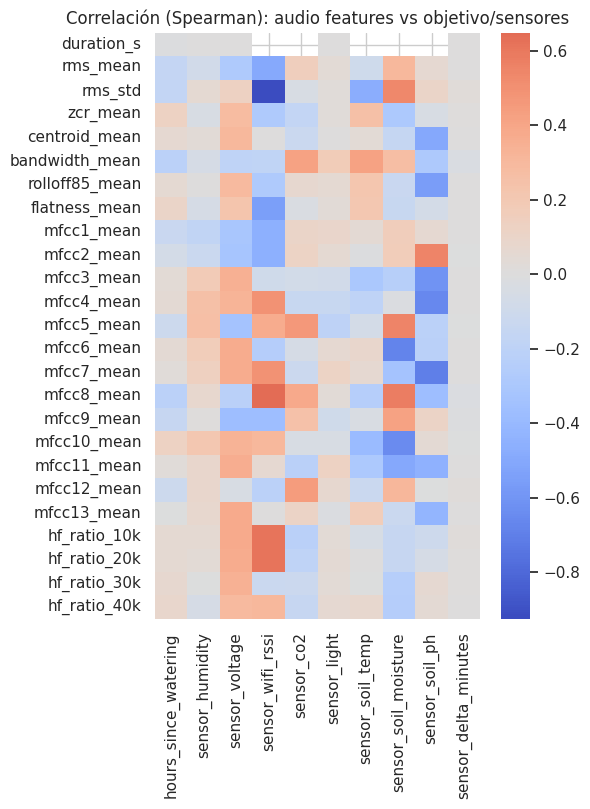

,hours_since_watering,sensor_humidity,sensor_voltage,sensor_wifi_rssi,sensor_co2,sensor_light,sensor_soil_temp,sensor_soil_moisture,sensor_soil_ph,sensor_delta_minutes
mfcc8_mean,-0.217423,0.073144,-0.224896,0.648074,0.385299,0.029579,-0.240196,0.579542,-0.370008,-0.021359
bandwidth_mean,-0.211809,-0.058632,-0.193728,-0.185164,0.418803,0.180751,0.416667,0.271275,-0.285189,-0.027927
rms_std,-0.174375,0.056426,0.134134,-0.925820,-0.045470,0.022898,-0.475490,0.533919,0.102029,0.023805
rms_mean,-0.162153,-0.081753,-0.277467,-0.493771,0.151453,0.039678,-0.100490,0.305801,0.059005,0.000121
mfcc9_mean,-0.145248,0.014585,-0.366669,-0.370328,0.244444,-0.094059,-0.034314,0.420477,0.110634,-0.011731
mfcc1_mean,-0.135086,-0.179043,-0.313009,-0.462910,0.101538,0.092804,0.049020,0.156600,0.062692,-0.000458
zcr_mean,0.131571,-0.037943,0.281870,-0.277746,-0.169915,0.021546,0.259804,-0.293470,-0.036878,0.013213
mfcc10_mean,0.125961,0.208067,0.338167,0.308607,-0.038632,-0.045082,-0.394608,-0.644895,0.046712,-0.009473
mfcc12_mean,-0.113634,0.077036,-0.045115,-0.216025,0.448205,0.066575,-0.132353,0.314433,-0.008605,0.015580
mfcc5_mean,-0.108295,0.264661,-0.333398,0.370328,0.457778,-0.195038,-0.071078,0.549949,-0.212662,-0.008400


In [9]:
# Correlaciones: características de audio vs objetivo y sensores
subset_vars = [TARGET] + sensor_cols
sub = df_feat[audio_cols + subset_vars].copy()
sub = sub.dropna(subset=audio_cols)
corr_mat = sub.corr(method='spearman')
corr_audio_vs_vars = corr_mat.loc[audio_cols, subset_vars]
plt.figure(figsize=(min(14, 2+0.4*len(subset_vars)), min(10, 2+0.25*len(audio_cols))))
sns.heatmap(corr_audio_vs_vars, cmap='coolwarm', center=0)
plt.title('Correlación (Spearman): audio features vs objetivo/sensores')
plt.tight_layout()
plt.show()
corr_audio_vs_vars.sort_values(by=TARGET, key=lambda s: np.abs(s), ascending=False).head(10)

### Cómo leer el mapa de calor
- Celdas rojas/azules intensas indican asociación monotónica fuerte (positiva/negativa).
- Las filas son características de audio; las columnas, el objetivo y sensores.
- Observa si el objetivo `hours_since_watering` destaca frente a sensores concretos.

In [11]:
# Prueba de predicción: ¿qué variable se predice mejor con audio?
results = []
X = df_feat[audio_cols].copy()
X = X.fillna(X.median(numeric_only=True))
candidates = []
if TARGET in df_feat.columns:
    candidates.append((TARGET, 'target'))
for c in sensor_cols:
    # Excluir sensores con demasiados NaN
    if df_feat[c].notna().mean() < 0.8:
        continue
    candidates.append((c, 'sensor'))

for var, kind in candidates:
    y = df_feat[var].copy()
    m = y.notna()
    Xy = X[m]
    yy = y[m]
    if len(Xy) < 100:
        continue
    X_tr, X_va, y_tr, y_va = train_test_split(Xy, yy, test_size=0.2, random_state=RANDOM_STATE)
    pipe = Pipeline([('scaler', StandardScaler()), ('ridge', RidgeCV(alphas=np.logspace(-3,3,13)) )])
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_va)
    r2 = r2_score(y_va, pred)
    mae = mean_absolute_error(y_va, pred)
    try:
        rmse = mean_squared_error(y_va, pred, squared=False)
    except TypeError:
        # Compatibilidad con versiones antiguas de sklearn sin 'squared'
        rmse = np.sqrt(mean_squared_error(y_va, pred))
    results.append({'variable': var, 'kind': kind, 'R2': r2, 'MAE': mae, 'RMSE': rmse})

res_df = pd.DataFrame(results).sort_values('R2', ascending=False)
res_df.head(20)

,variable,kind,R2,MAE,RMSE
0,hours_since_watering,target,0.165563,27.957650,39.199472
1,sensor_delta_minutes,sensor,-0.004034,3.771476,4.344761


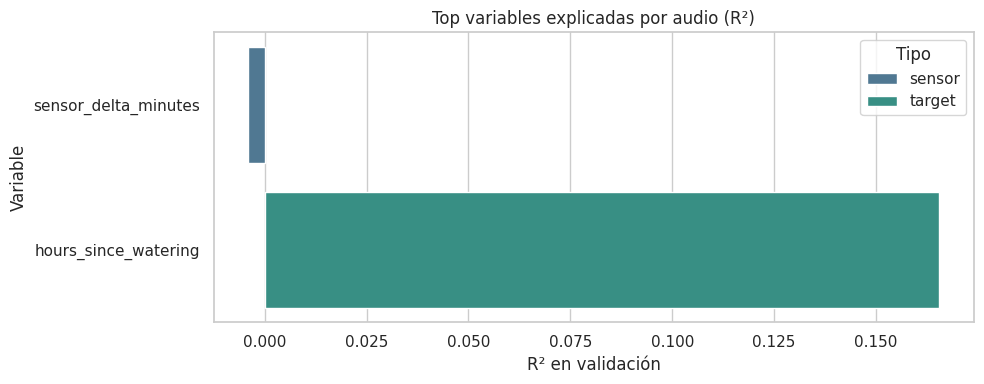

In [12]:
# Visualizar top variables por R²
topk = 15
top_res = res_df.head(topk).iloc[::-1]
plt.figure(figsize=(10, max(4, 0.4*len(top_res))))
sns.barplot(x='R2', y='variable', data=top_res, hue='kind', dodge=False, palette={'target':'#2a9d8f','sensor':'#457b9d'})
plt.title('Top variables explicadas por audio (R²)')
plt.xlabel('R² en validación')
plt.ylabel('Variable')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()

### Interpretación
- R² cercano a 1: la variable se explica muy bien con las características de audio; cercano a 0: poca explicación.
- Si `hours_since_watering` aparece en los primeros puestos (R² alto), el audio probablemente codifica el tiempo desde el riego.
- Si destacan sensores concretos (p.ej., humedad, temperatura), el audio podría estar reflejando más esos fenómenos.
- Revisa también el signo y magnitud de correlaciones para entender cómo cambian las variables con el audio.